# Modeling the Affinity of Customers

## Import libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Train/test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# ColumnTransformer
from sklearn.compose import ColumnTransformer

# Oversampling SMOTE
from imblearn.over_sampling import SMOTE

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classification report
from sklearn.metrics import classification_report

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
# Import csv files as pandas dataframe
customer = pd.read_csv("data/rest.csv", sep = ";")
age_and_sex = pd.read_csv("data/alter_geschlecht.csv")
interest = pd.read_csv("data/interesse.csv")

In [262]:
customer.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [263]:
age_and_sex.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [264]:
interest.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [265]:
# Exploring lenght of the tables
print(len(customer))
print(len(age_and_sex))
print(len(interest))

508146
508146
381109


Interest table contains fewer rows than two other tables => In this scenario, we should only keep the rows in the "customer" and "age_and_sex" dataframes that match the IDs in the "interest" dataframe since the "interest" dataframe contains the target variable we want to predict. The rest we can keep for predicting after training the model

In [3]:
# Merge dataframes -> use left join for interest table
data = interest.merge(age_and_sex, on='id', how='left')
data = data.merge(customer, on='id', how='left')
data.head()

,id,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,1.0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,0.0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,1.0,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,0.0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,0.0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [291]:
# Examine the structure of the table
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               381109 non-null  int64  
 1   Interesse        381109 non-null  float64
 2   Geschlecht       381109 non-null  object 
 3   Alter            381109 non-null  int64  
 4   Fahrerlaubnis    381109 non-null  int64  
 5   Regional_Code    381109 non-null  float64
 6   Vorversicherung  381109 non-null  int64  
 7   Alter_Fzg        381109 non-null  object 
 8   Vorschaden       381109 non-null  object 
 9   Jahresbeitrag    381109 non-null  float64
 10  Vertriebskanal   381109 non-null  float64
 11  Kundentreue      381109 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 37.8+ MB
None


In [292]:
# Explore missing values
print(data.isna().sum()) # -> no missing values

id                 0
Interesse          0
Geschlecht         0
Alter              0
Fahrerlaubnis      0
Regional_Code      0
Vorversicherung    0
Alter_Fzg          0
Vorschaden         0
Jahresbeitrag      0
Vertriebskanal     0
Kundentreue        0
dtype: int64


In [293]:
# Explore duplicated rows
print(data.duplicated().sum()) # -> no duplicates

0


In [294]:
# Detecting outliers

# Check categorical features on unexpected values
print(data["Interesse"].unique())
print(data["Geschlecht"].unique())
print(data["Fahrerlaubnis"].unique())
print(data["Vorversicherung"].unique())
print(data["Alter_Fzg"].unique())
print(data["Vorschaden"].unique())

[1. 0.]
['Male' 'Female']
[1 0]
[0 1]
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']


In [295]:
# Check values in Regional_Code
np.sort(data['Regional_Code'].unique()) # -> 53 regions

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [296]:
# Check values in Vertriebskanal
np.sort(data['Vertriebskanal'].unique()) # -> 163 channels

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

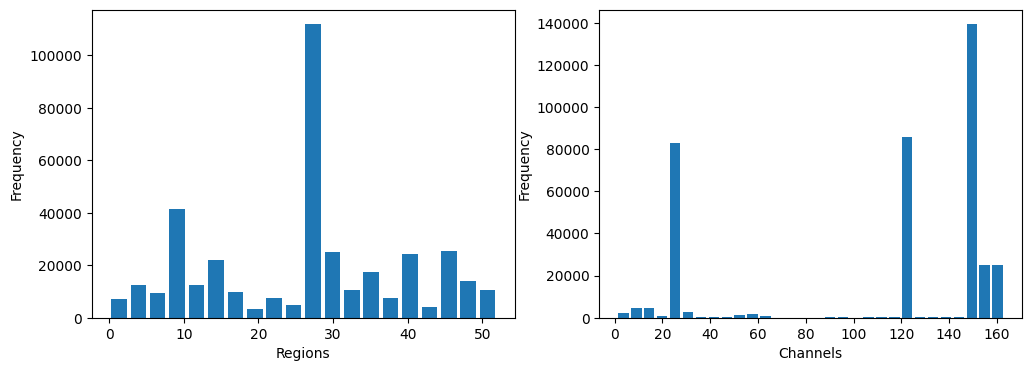

In [297]:
# Check Regional_Code and Vertriebskanal distribution
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Regional_Code'], bins=20, rwidth=0.8)
plt.xlabel('Regions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Vertriebskanal'], bins=30, rwidth=0.8)
plt.xlabel('Channels')
plt.ylabel('Frequency')

plt.show()

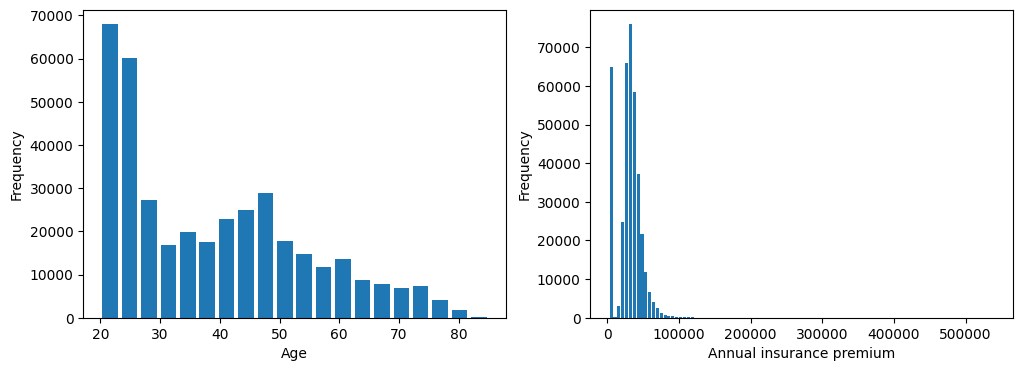

In [232]:
# Check numerical features

# Check age and annual premium
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Alter'], bins=20, rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Jahresbeitrag'], bins=100, rwidth=0.8)
plt.xlabel('Annual insurance premium')
plt.ylabel('Frequency')

plt.show()

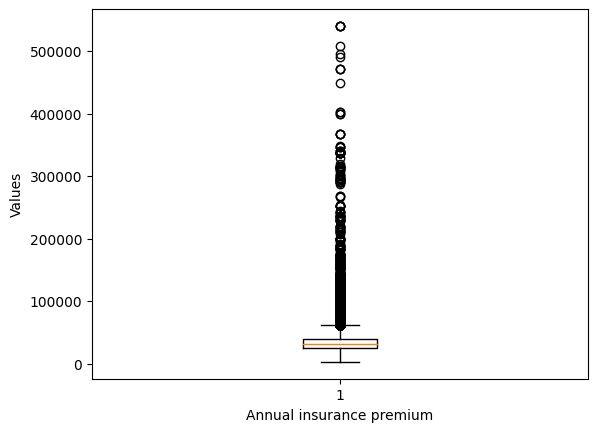

In [484]:
# Plot boxplot of Jahresbeitrag column
plt.boxplot(data['Jahresbeitrag'])
plt.xlabel('Annual insurance premium')
plt.ylabel('Values')
plt.show()

There are clearly outliers in Jahresbeitrag column. We can further check it IQR

In [4]:
# Calculate the quartiles
Q1 = data['Jahresbeitrag'].quantile(0.25)
Q3 = data['Jahresbeitrag'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = data[(data['Jahresbeitrag'] < lower_bound) | (data['Jahresbeitrag'] > upper_bound)]

In [5]:
num_outliers = len(outliers)
num_non_outliers = len(data) - num_outliers
ratio = (num_outliers / len(data)) * 100
print("Percentage of outliers: {:.2f}%".format(ratio))

Percentage of outliers: 2.71%


There are different approaches for dealing with outliers. For now I would just remove outliers. Normally, it is only recommended if the outliers are due to measurement error or other issues and not to actual differences in the data. Since I don't know the nature of outlier and their persentage in the whode data is not so big, I will remove them

In [6]:
data = data[~data['Jahresbeitrag'].isin(outliers['Jahresbeitrag'])]

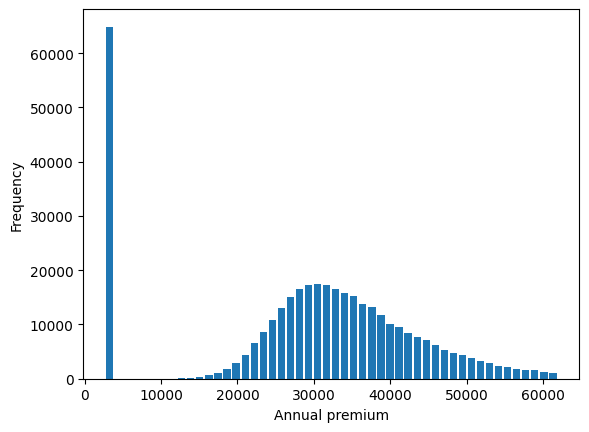

In [526]:
# Check values in Jahresbeitrag
plt.hist(data['Jahresbeitrag'], bins=50, rwidth=0.8)
plt.xlabel('Annual premium')
plt.ylabel('Frequency')
plt.show()

The data is still not normally distributed. The peak at low values may suggest that the huge proportion of customers has not very expensive annual premium. It might be useful to split the data into two or more groups based on the high peak at low values and the kind of normal distribution at around 30000

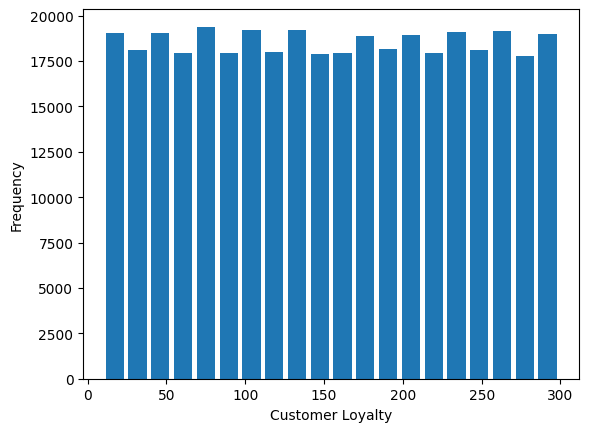

In [527]:
# Check values in Kundentreue
plt.hist(data['Kundentreue'], bins=20, rwidth=0.8)
plt.xlabel('Customer Loyalty')
plt.ylabel('Frequency')
plt.show()

If the data is equally distributed over all the range of values, it suggests that the data does not have any specific pattern or bias. In this case, we don't need to perform any specific pre-processing to the data, such as log-transformation or standardization. 

Conclusions:
We have 7 categoracal variables: Geschlecht, Fahrerlaubnis, Regional_Code, Vorversicherung, Alter_Fzg, Vorschaden and Vertriebskanal. Some of them need to be encoded:
* Geschlecht -> one-hot-encoding since they don't have ordinal structure
* Alter_Fzg -> ordinal encoder since they have hierarchy
* Vorschaden -> label encoder that put 1 if there are previous damages and 0 if not
* Regional_Code and Vertriebskanal -> it is necessary to encode them using different strategy since some algorithms are sensitive to the ordering of the categories and may assign a higher weight to categories with larger numerical values -> use target encoding

Our numerical values are: Alter, Jahresbeitrag and Kundentreue.

* Jahresbeitrag -> has two peaks -> discretize based on these peaks
* Alter -> it may make sense to discretize Alter column into groups according to car accident statistics (https://www.gdv.de/gdv/themen/mobilitaet/so-wirkt-sich-das-alter-auf-den-kfz-versicherungsbeitrag-aus-12464)
* Kundentreue -> MinMax Scaling

Note: I will first proceed with logistic regression, such algorithms assume that the input variables are on the same scale and that the scale of the coefficients is meaningful. That is why I need to scale my variables. I will also later try other algorithms such as random forest. Such algorithms are not sensitive to the scale of the features, so normalization or scaling is not necessary. But still scaling doesn't hurt.

## Feature Engineering and Encoding

In [7]:
# Discretize Jahresbeitrag column

# Threshold value to split the column into two groups
threshold = 7000

# Create a new column to store the group labels
data['Jahresbeitrag_bin'] = "high"
data.loc[data['Jahresbeitrag'] < threshold, 'Jahresbeitrag_bin'] = "low"

# Check the split
print(data.groupby('Jahresbeitrag_bin')['Jahresbeitrag'].count())

Jahresbeitrag_bin
high    305911
low      64878
Name: Jahresbeitrag, dtype: int64


In [8]:
# One-hot encoding of Jahresbeitrag_bin column

# Define the mapping from original categorical values to encoded values
ordinal_mapping = {'low': 0, 'high': 1}

# Use the map function to perform the encoding
data['Jahresbeitrag_bin_enc'] = data['Jahresbeitrag_bin'].map(ordinal_mapping)

# Drop the columns which have been encoded
data.drop(columns = ["Jahresbeitrag_bin"], inplace = True)
data.drop(columns = ["Jahresbeitrag"], inplace = True)

In [9]:
# Discretize Alter column
bins = [0, 30, 50, 65, 75, 100]
bin_labels = ['<30', '30-50', '50-65', '65-75', '>75']
data['Alter_binned'] = pd.cut(data['Alter'], bins=bins, labels=bin_labels, right=False)

# one-hot encode the Alter_binned column
data = pd.get_dummies(data, columns=['Alter_binned'])

# Drop Alter column
data.drop(columns = ["Alter"], inplace = True)

In [10]:
# Drop the column "id" since we don't need it anymore
data.drop(columns = ["id"], inplace = True)

In [11]:
# Encoding Regional_Code and Vertriebskanal 

# Import function from utils
from utils.functions import calc_target_encoding

# Apply function to Regional_Code and Vertriebskanal columns
target_mean_regional = calc_target_encoding(data, 'Regional_Code', 'Interesse')
target_mean_channel = calc_target_encoding(data, 'Vertriebskanal', 'Interesse')

# Apply target encoding to the original data
data['Regional_Code_enc'] = data['Regional_Code'].map(target_mean_regional)
data['Vertriebskanal_enc'] = data['Vertriebskanal'].map(target_mean_channel)

# Drop columns which have been encoded
data.drop(columns = ["Regional_Code"], inplace = True)
data.drop(columns = ["Vertriebskanal"], inplace = True)

In [12]:
# Alter_Fzg

# Instantiate the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Define the mapping for each category in the "Alter_Fzg" column
ordinal_mapping = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}

# Creating an array that contains the categories of the "Alter_Fzg" column
Alter_Fzg_array = data['Alter_Fzg'].map(lambda x: ordinal_mapping[x]).values.reshape(-1, 1)

# Fit and transform the Alter_Fzg_array to a numerical representation
Alter_Fzg_encoded = ordinal_encoder.fit_transform(Alter_Fzg_array)

# Adding the encoded "Alter_Fzg" column to the original dataframe
data['Alter_Fzg_enc'] = Alter_Fzg_encoded

# Drop the column "Alter_Fzg" which has been encoded
data.drop(columns = ["Alter_Fzg"], inplace = True)

In [13]:
# Geschlecht

# Instantiate the OneHotEncoder
ohe_binary = OneHotEncoder(sparse = False, drop="if_binary") 

# Fit encoder
ohe_binary.fit(data[['Geschlecht']]) 

# Transform the current "Geschlecht" column
data[ohe_binary.get_feature_names_out()] = ohe_binary.transform(data[['Geschlecht']])

# Drop the column "Geschlecht" which has been encoded
data.drop(columns = ["Geschlecht"], inplace = True)

In [14]:
# Vorschaden

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the Vorschaden column
data['Vorschaden'] = le.fit_transform(data['Vorschaden'].values)

In [541]:
data.head()

,Interesse,Fahrerlaubnis,Vorversicherung,Vorschaden,Kundentreue,Jahresbeitrag_bin_enc,Alter_binned_<30,Alter_binned_30-50,Alter_binned_50-65,Alter_binned_65-75,Alter_binned_>75,Regional_Code_enc,Vertriebskanal_enc,Alter_Fzg_enc,Geschlecht_Male
0,1.0,1,0,1,217,1,0,1,0,0,0,0.187163,0.199385,2.0,1.0
1,0.0,1,0,0,183,1,0,0,0,0,1,0.127662,0.199385,1.0,1.0
2,1.0,1,0,1,27,1,0,1,0,0,0,0.187163,0.199385,2.0,1.0
3,0.0,1,1,0,203,1,1,0,0,0,0,0.112760,0.028624,0.0,1.0
4,0.0,1,1,0,39,1,1,0,0,0,0,0.121776,0.028624,0.0,0.0


## Preprocessing Pipeline

In [15]:
# Defining the features and the target
X = data.drop(columns='Interesse')
y = data['Interesse']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((259552, 14), (111237, 14), (259552,), (111237,))

In [16]:
# Scale numerical values: 
num_transformer = Pipeline([('minmax_scaler', MinMaxScaler())])

# Parallelize transformers
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Kundentreue'])],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Kundentreue'])])

In [17]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [18]:
norm_data = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out())

norm_data_test = pd.DataFrame(
    X_test_transformed, 
    columns=preprocessor.get_feature_names_out())

In [19]:
norm_data.head()

,num_transformer__Kundentreue,remainder__Fahrerlaubnis,remainder__Vorversicherung,remainder__Vorschaden,remainder__Jahresbeitrag_bin_enc,remainder__Alter_binned_<30,remainder__Alter_binned_30-50,remainder__Alter_binned_50-65,remainder__Alter_binned_65-75,remainder__Alter_binned_>75,remainder__Regional_Code_enc,remainder__Vertriebskanal_enc,remainder__Alter_Fzg_enc,remainder__Geschlecht_Male
0,0.844291,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.121621,0.246689,0.0,0.0
1,0.283737,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.130987,0.028759,0.0,0.0
2,0.813149,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097553,0.189675,1.0,1.0
3,0.557093,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.187526,0.028759,0.0,1.0
4,0.262976,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.187526,0.172469,1.0,0.0


## Preliminary Statistical Analysis

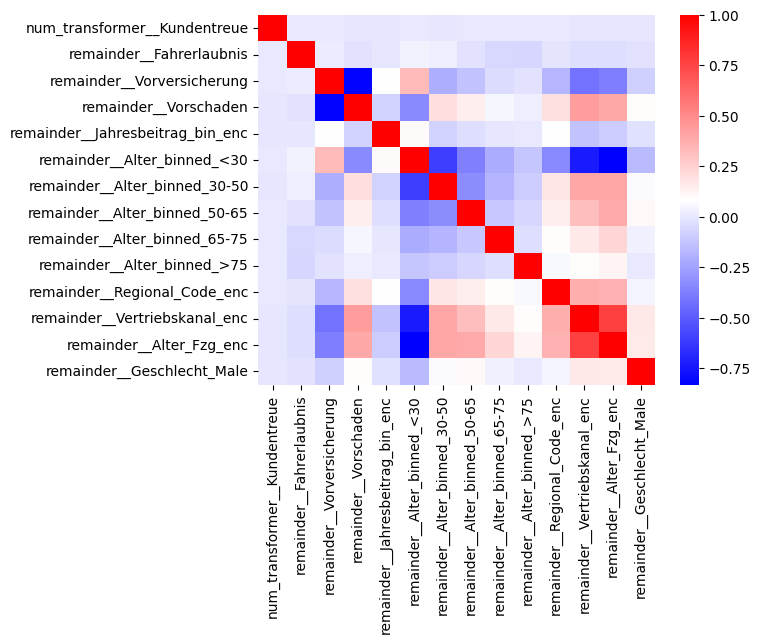

In [20]:
# Heatmap of pairwise correlations
correlation_matrix = norm_data.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [21]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [22]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
82,remainder__Alter_binned_<30,remainder__Alter_Fzg_enc,-0.831481,0.831481
173,remainder__Alter_Fzg_enc,remainder__Alter_binned_<30,-0.831481,0.831481
44,remainder__Vorschaden,remainder__Vorversicherung,-0.823819,0.823819
31,remainder__Vorversicherung,remainder__Vorschaden,-0.823819,0.823819
179,remainder__Alter_Fzg_enc,remainder__Vertriebskanal_enc,0.769153,0.769153
166,remainder__Vertriebskanal_enc,remainder__Alter_Fzg_enc,0.769153,0.769153
81,remainder__Alter_binned_<30,remainder__Vertriebskanal_enc,-0.731720,0.731720
159,remainder__Vertriebskanal_enc,remainder__Alter_binned_<30,-0.731720,0.731720
89,remainder__Alter_binned_30-50,remainder__Alter_binned_<30,-0.604029,0.604029
76,remainder__Alter_binned_<30,remainder__Alter_binned_30-50,-0.604029,0.604029


## Logistic Regression Modell

### Choosing the right metrics

In [23]:
target_count = data['Interesse'].value_counts()
print("Class distribution:")
print(target_count)

Class distribution:
0.0    325634
1.0     45155
Name: Interesse, dtype: int64


In [24]:
# Calculate the ratio of each class
class_ratio = target_count[1] / target_count[0]
print("Ratio of classes:", class_ratio)

Ratio of classes: 0.13866795236369667


Target classes are not balanced -> accuracy isn't an option. Recall is a better choice since we don't want to miss any positive classes (customers that have interest in offer). We want to reduce false negatives (customers who are interested in offer but were recognized as not-interested). 

We can also use F1 score as a combination of precision and recall

### Pipeline

In [25]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000) 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Kundentreue'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [560]:
# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.0022274470589577124
Mean precision score: 0.426634402097197


We have an imbalanced dataset and the mean recall score is extremely low, it's likely that the model is biased towards the majority class and is not detecting the minority class well. We can try to oversample minority class.

In [28]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit the SMOTE model to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the SMOTE model to the test data
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [562]:
# Cross-validate the model again
recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.9125310615943081
Mean precision score: 0.7469181609149025


It is now far better. We can also try to find good precision-recall tradeoff and optimize threshold for logistic model

### Precision-Recall Tradeoff

In [563]:
df = pd.DataFrame()
df['interest'] = y_train_resampled

In [564]:
# Predict class probabilties
df['proba_no_interest'], df['proba_interest'] =cross_val_predict(pipeline,
                                                                X_train_resampled,
                                                                df['interest'],
                                                                cv=5,
                                                                method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(df['interest'],
                                                      df['proba_interest']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.5        0.50000107 0.50000214 0.50000321 0.50000427]
recall- [1. 1. 1. 1. 1.]
threshold- [5.68360526e-06 1.07971500e-05 1.12771481e-05 1.13105288e-05
 1.13449026e-05]


In [565]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.000006,0.500000,1.000000
1,0.000011,0.500001,1.000000
2,0.000011,0.500002,1.000000
3,0.000011,0.500003,1.000000
4,0.000011,0.500004,1.000000
...,...,...,...
398812,0.996839,1.000000,0.000021
398813,0.996894,1.000000,0.000017
398814,0.997105,1.000000,0.000013
398815,0.997181,1.000000,0.000009


Text(0.5, 0, 'recall')

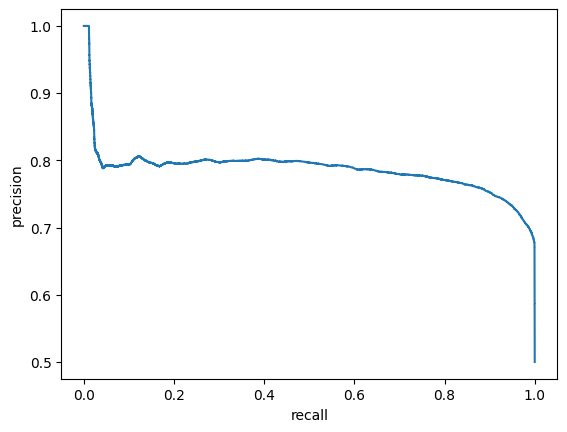

In [566]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [567]:
custom_threshold = scores[scores['recall'] >= 0.8].threshold.max()
custom_threshold

0.6696882610996339

In [568]:
pipeline.fit(X_train_resampled, y_train_resampled)

def custom_predict(X, custom_threshold):
    probs = pipeline.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1
    expensive_probs = probs[:, 1] # Only keep expensive likelihoods (1) 
    return (expensive_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1
    
    
updated_preds = custom_predict(X=X_train_resampled, custom_threshold=custom_threshold) # Update predictions 

print("Recall:", recall_score(df['interest'], updated_preds)) # Rerun recall
print("Precision:", precision_score(df['interest'], updated_preds)) # Rerun precision
print("F1 Score:", f1_score(df['interest'], updated_preds)) # Rerun f1

Recall: 0.8001136737563194
Precision: 0.7707117276581731
F1 Score: 0.7851375350416095


Recall decreased from 91 to 80 => do not proceed with custom threshold

### Feature Permutation and Complexity Reduction

In [569]:
# Cross Validation
np.mean(cross_val_score(pipeline, X_train_resampled, y_train_resampled , cv=5))

0.8016670808313666

In [570]:
from sklearn.inspection import permutation_importance

# Fit model
log_model = pipeline.fit(X_train_resampled, y_train_resampled) 

# Performs Permutation
permutation_score = permutation_importance(log_model, X_train_resampled, y_train_resampled, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_resampled.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df['score decrease'] = importance_df['score decrease'].abs()

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
5,Alter_binned_<30,0.095998
2,Vorschaden,0.094052
1,Vorversicherung,0.085739
7,Alter_binned_50-65,0.048281
6,Alter_binned_30-50,0.044436
11,Vertriebskanal_enc,0.030531
8,Alter_binned_65-75,0.017978
9,Alter_binned_>75,0.007722
10,Regional_Code_enc,0.004009
4,Jahresbeitrag_bin_enc,0.000527


In [574]:
# Drop the weakest feature
X_train_resampled.drop(columns = ["Geschlecht_Male"], inplace = True)

In [575]:
# Re-instantiate pipeline
log_model = pipeline.fit(X_train_resampled, y_train_resampled) 

# Cross-validate the model again
recall_scores = cross_val_score(log_model, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

recall_scores = cross_val_score(log_model, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.9119327739180093
Mean precision score: 0.7471672066021359


A litte bit better but not significant

### Model Evaluation 

In [576]:
# Instantiate model
pipeline.fit(X_train_resampled, y_train_resampled) 

# Predict the target classes on the test set
y_pred = pipeline.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81    100396
         1.0       0.29      0.90      0.44     13937

    accuracy                           0.72    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.72      0.77    114333



Not perfect results => try some other model

## Random Forest Model

In [577]:
# Instantiate model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Add estimator
pipeline = make_pipeline(preprocessor, random_forest)
pipeline

# Train the random forest model
pipeline.fit(X_train_resampled, y_train_resampled)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.8948225581234384
Mean precision score: 0.8746481327920732


In [29]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit the SMOTE model to the normalized training data
X_train_resampled, y_train_resampled = smote.fit_resample(norm_data, y_train)

# Fit the SMOTE model to the normalized test data
X_test_resampled, y_test_resampled = smote.fit_resample(norm_data_test, y_test)

In [585]:
# Create the classifier
random_forest = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [586]:
best_params

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [31]:
best_params = {'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [32]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Use recall as the scoring metric
recall_scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
recall_scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.9367372622622684
Mean precision score: 0.7403503137177945


In [33]:
random_forest.fit(X_train_resampled, y_train_resampled)

# Predict the target classes on the test set
y_pred = random_forest.predict(X_test_resampled)

# Calculate the classification report
report = classification_report(y_test_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.90      0.68      0.78     97680
         1.0       0.74      0.92      0.82     97680

    accuracy                           0.80    195360
   macro avg       0.82      0.80      0.80    195360
weighted avg       0.82      0.80      0.80    195360



In [596]:
# Create the classifier
random_forest = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [6, 7, 8],
    'max_depth': [9, 10, 11],
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [1]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

best_params

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 8}

In [34]:
best_params = {'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 8}

In [35]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Use recall as the scoring metric
recall_scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
recall_scores = cross_val_score(random_forest, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

Mean recall score: 0.9501873646775421
Mean precision score: 0.744900379948635


In [36]:
random_forest.fit(X_train_resampled, y_train_resampled)

# Predict the target classes on the test set
y_pred = random_forest.predict(X_test_resampled)

# Calculate the classification report
report = classification_report(y_test_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.69      0.78     97680
         1.0       0.75      0.93      0.83     97680

    accuracy                           0.81    195360
   macro avg       0.83      0.81      0.81    195360
weighted avg       0.83      0.81      0.81    195360



## Support Vector Machines 

In [ ]:
svm = SVC()

# Train the random forest model
svm.fit(X_train_resampled, y_train_resampled)

# Use recall as the scoring metric
recall_scores = cross_val_score(svm, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
recall_scores = cross_val_score(svm, X_train_resampled, y_train_resampled, cv=5, scoring='precision')
mean_recall = recall_scores.mean()
print("Mean precision score:", mean_recall)

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create the classifier
svm = SVC()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

## SDGClassifier

In [44]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_resampled, y_train_resampled)

# Use recall as the scoring metric
recall_scores = cross_val_score(sgd_clf, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)


Mean recall score: 0.9766531812757151


In [40]:
param_grid = {
    'loss': ['hinge', 'log', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_params

/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradie

/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradie

/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/mariiamorskovatykh/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


{'alpha': 0.1, 'loss': 'perceptron', 'penalty': 'l1'}

In [53]:
param_grid = {
    'alpha': [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
}

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_params

{'alpha': 0.4}

In [54]:
sgd_clf = SGDClassifier(alpha= 0.4)
sgd_clf.fit(X_train_resampled, y_train_resampled)

# Use recall as the scoring metric
recall_scores = cross_val_score(sgd_clf, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)


Mean recall score: 0.9902260963804033


In [55]:
sgd_clf = SGDClassifier(alpha= 0.3)
sgd_clf.fit(X_train_resampled, y_train_resampled)

# Predict the target classes on the test set
y_pred = sgd_clf.predict(X_test_resampled)

# Calculate the classification report
report = classification_report(y_test_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.54      0.69     97680
         1.0       0.68      0.99      0.81     97680

    accuracy                           0.76    195360
   macro avg       0.83      0.76      0.75    195360
weighted avg       0.83      0.76      0.75    195360



In [58]:
# Performs Permutation
permutation_score = permutation_importance(sgd_clf, X_train_resampled, y_train_resampled, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_resampled.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df['score decrease'] = importance_df['score decrease'].abs()

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
3,remainder__Vorschaden,0.079462
2,remainder__Vorversicherung,0.076658
5,remainder__Alter_binned_<30,0.002895
12,remainder__Alter_Fzg_enc,0.001876
6,remainder__Alter_binned_30-50,0.000346
11,remainder__Vertriebskanal_enc,0.000002
8,remainder__Alter_binned_65-75,0.000002
10,remainder__Regional_Code_enc,0.000002
7,remainder__Alter_binned_50-65,0.000001
0,num_transformer__Kundentreue,0.0


In [69]:
# Drop the weakest feature
#X_train_resampled.drop(columns = ["remainder__Geschlecht_Male"], inplace = True)
#X_train_resampled.drop(columns = ["remainder__Alter_binned_>75"], inplace = True)
#X_train_resampled.drop(columns = ["remainder__Jahresbeitrag_bin_enc"], inplace = True)
X_train_resampled.drop(columns = ["remainder__Fahrerlaubnis"], inplace = True)


#X_test_resampled.drop(columns = ["remainder__Geschlecht_Male"], inplace = True)
#X_test_resampled.drop(columns = ["remainder__Alter_binned_>75"], inplace = True)
X_test_resampled.drop(columns = ["remainder__Fahrerlaubnis"], inplace = True)

In [70]:
sgd_clf = SGDClassifier(alpha= 0.3)
sgd_clf.fit(X_train_resampled, y_train_resampled)

# Predict the target classes on the test set
y_pred = sgd_clf.predict(X_test_resampled)

# Calculate the classification report
report = classification_report(y_test_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.54      0.69     97680
         1.0       0.68      0.99      0.81     97680

    accuracy                           0.76    195360
   macro avg       0.83      0.76      0.75    195360
weighted avg       0.83      0.76      0.75    195360

